<a href="https://colab.research.google.com/github/radonys/virality-predictor/blob/dev/Virality_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Virality Predictor

### Import Modules

In [ ]:
import os
import pandas as pd
from datetime import datetime
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer

import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load Data

#### Shared Articles

In [ ]:
articles = pd.read_csv("/content/shared_articles.csv")
articles.shape

(3122, 13)

#### User Interactions

In [ ]:
interactions = pd.read_csv("/content/users_interactions.csv")
len(interactions['contentId'].unique())

2987

### Process and Analyse Data

#### Count Views, Likes, Comments, Follows and Bookmarks for each ContentID

In [ ]:
counts = interactions[['contentId', 'eventType', 'timestamp']].groupby(['contentId', 'eventType']).count()
counts.columns = ['count']

counts = pd.pivot_table(counts, values=['count'], index=['contentId'], columns=['eventType'], fill_value=0)['count']
counts.reset_index(inplace=True)
counts.head()

eventType,contentId,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW
0,-9222795471790223670,1,2,3,4,16
1,-9216926795620865886,1,1,1,3,15
2,-9194572880052200111,2,1,1,4,21
3,-9192549002213406534,0,1,0,5,50
4,-9190737901804729417,0,0,0,1,8


#### Calculate Virality

**Given Formulation: VIRALITY = 1 * VIEW + 4 * LIKE + 10 * COMMENT + 25 * FOLLOW + 100 * BOOKMARK**

In [ ]:
counts['VIRALITY'] = 1*counts['VIEW'] + 4*counts['LIKE'] + 10*counts['COMMENT CREATED'] + 25*counts['FOLLOW'] + 100*counts['BOOKMARK']
counts.head()

eventType,contentId,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
0,-9222795471790223670,1,2,3,4,16,227
1,-9216926795620865886,1,1,1,3,15,162
2,-9194572880052200111,2,1,1,4,21,272
3,-9192549002213406534,0,1,0,5,50,80
4,-9190737901804729417,0,0,0,1,8,12


#### Analyse Distribution of Count Data

In [ ]:
counts.describe()

eventType,contentId,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
count,2.987000e+03,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000
mean,1.906772e+16,0.824573,0.539337,0.471041,1.923334,20.450619,127.770673
std,5.382564e+18,2.231426,1.292221,1.076175,3.368695,27.199921,259.044552
min,-9.222795e+18,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-4.685855e+18,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000
50%,3.134908e+16,0.000000,0.000000,0.000000,1.000000,12.000000,43.000000
75%,4.716572e+18,1.000000,1.000000,1.000000,2.000000,25.000000,150.000000
max,9.222265e+18,78.000000,13.000000,14.000000,53.000000,355.000000,7907.000000


#### Analyse ContentIDs in articles and user interactions

In [ ]:
article_unique = set(articles['contentId'])
interactions_unique = set(counts['contentId'])

print("Number of unique ContentID in articles: ", len(article_unique))
print("Number of ContentID in counts: ", len(interactions_unique))

Number of unique ContentID in articles:  3057
Number of ContentID in counts:  2987


In [ ]:
content_ids_not_available = article_unique.difference(interactions_unique)
print("Number of ContentID not present in interactions: ", len(content_ids_not_available))

content_ids_not_available = interactions_unique.difference(article_unique)
print("Number of ContentID not present in articles: ", len(content_ids_not_available))

Number of ContentID not present in interactions:  70
Number of ContentID not present in articles:  0


##### Hence, the dataset has no user interaction information for 70 articles. 

#### Join Articles and Counts of User Interaction

In [ ]:
data = articles.set_index('contentId').join(counts.set_index('contentId'), how = 'inner')
data.head()

,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
contentId,,,,,,,,,,,,,,,,,,
-9222795471790223670,1465870439,CONTENT SHARED,-5868110530814399805,1607781139334257479,NaN,NaN,NaN,HTML,http://idgnow.com.br/mobilidade/2016/06/13/ube...,Uber lança serviço de helicóptero em SP com pr...,"O Uber anunciou nesta segunda-feira, 13/06, o ...",pt,1,2,3,4,16,227
-9216926795620865886,1467662560,CONTENT SHARED,-7711052404720939396,-1358388252171356050,NaN,NaN,NaN,HTML,http://maggiesensei.com/2012/11/14/request-les...,Request lesson : How and when to use はず(=hazu)...,= Kotoshi no aki made niwa kare ga dekiru hazu...,la,1,1,1,3,15,162
-9194572880052200111,1485266665,CONTENT SHARED,2279740393166882579,-2981318194211766525,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,HTML,http://br-arduino.org/2017/01/stemtera-uma-pro...,"STEMTera, uma protoboard com Arduino Uno embutido",Protoboard de 400 pinos + Arduino Uno em um só...,pt,2,1,1,4,21,272
-9192549002213406534,1461531427,CONTENT SHARED,-1578287561410088674,-5843888580106500275,NaN,NaN,NaN,HTML,http://thenextweb.com/dd/2016/04/20/googles-ch...,Chrome OS now has Material Design for the desktop,Chromebook users are in for a surprise: Chrome...,en,0,1,0,5,50,80
-9190737901804729417,1467653065,CONTENT SHARED,-108842214936804958,7085372222303681846,NaN,NaN,NaN,HTML,http://themacro.com/articles/2016/06/the-real-...,The Real Product Market Fit,"Michael Seibel, Y Combinator Partner, on knowi...",en,0,0,0,1,8,12


#### Remove Content Removed Rows

In [ ]:
data = data[data['eventType'] != 'CONTENT REMOVED']

#### Drop URL, contentType, eventType, NaN and ID columns

##### Identify columns having NaN

In [ ]:
data.isnull().any()

timestamp          False
eventType          False
authorPersonId     False
authorSessionId    False
authorUserAgent     True
authorRegion        True
authorCountry       True
contentType        False
url                False
title              False
text               False
lang               False
BOOKMARK           False
COMMENT CREATED    False
FOLLOW             False
LIKE               False
VIEW               False
VIRALITY           False
dtype: bool

##### Analyse NaN columns

In [ ]:
print("Number of rows with country information:", len(data['authorCountry'].dropna()), "out of", data.shape[0])
print("Number of rows with region information:", len(data['authorRegion'].dropna()), "out of", data.shape[0])
print("Number of rows with user agent information:", len(data['authorUserAgent'].dropna()), "out of", data.shape[0])

Number of rows with country information: 662 out of 2979
Number of rows with region information: 662 out of 2979
Number of rows with user agent information: 662 out of 2979


##### Since, 22% of the data rows contain the above information, it would be difficult to analyse it's effect on virality and hence dropped.

##### Analyse Content Type

In [ ]:
data['contentType'].value_counts()

HTML     2959
RICH       10
VIDEO      10
Name: contentType, dtype: int64

##### Since, more 95% has HTML content-type, it won't make a big difference over virality and hence dropped.

##### Drop columns

In [ ]:
data.drop(['authorUserAgent', 'authorCountry', 'authorRegion', 'authorSessionId', 'authorPersonId', 'url', 'contentType', 'eventType'], inplace=True, axis=1)
data.head()

,timestamp,title,text,lang,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
contentId,,,,,,,,,,
-9222795471790223670,1465870439,Uber lança serviço de helicóptero em SP com pr...,"O Uber anunciou nesta segunda-feira, 13/06, o ...",pt,1,2,3,4,16,227
-9216926795620865886,1467662560,Request lesson : How and when to use はず(=hazu)...,= Kotoshi no aki made niwa kare ga dekiru hazu...,la,1,1,1,3,15,162
-9194572880052200111,1485266665,"STEMTera, uma protoboard com Arduino Uno embutido",Protoboard de 400 pinos + Arduino Uno em um só...,pt,2,1,1,4,21,272
-9192549002213406534,1461531427,Chrome OS now has Material Design for the desktop,Chromebook users are in for a surprise: Chrome...,en,0,1,0,5,50,80
-9190737901804729417,1467653065,The Real Product Market Fit,"Michael Seibel, Y Combinator Partner, on knowi...",en,0,0,0,1,8,12


#### Process Language, Title and Text 

##### Counts of articles based on language

In [ ]:
data['lang'].value_counts()

en    2149
pt     823
la       3
es       2
ja       2
Name: lang, dtype: int64

##### Considering the scope of the project and above statistics, only English articles will be kept.

In [ ]:
data = data[data['lang'] == 'en']
data.head()

,timestamp,title,text,lang,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
contentId,,,,,,,,,,
-9192549002213406534,1461531427,Chrome OS now has Material Design for the desktop,Chromebook users are in for a surprise: Chrome...,en,0,1,0,5,50,80
-9190737901804729417,1467653065,The Real Product Market Fit,"Michael Seibel, Y Combinator Partner, on knowi...",en,0,0,0,1,8,12
-9189659052158407108,1470892968,Eddy Cue and Craig Federighi Open Up About Lea...,Fast Company : Let's start talking about Maps....,en,2,0,0,1,33,237
-9171475473795142532,1459423840,Decentralized Options Exchange Etheropt Uses A...,The price per Ether will be taken from multipl...,en,1,0,0,0,4,104
-9166778629773133902,1461067523,Google CDN Beta is here... and it's already on...,"Some months ago, Google launched their Alpha p...",en,0,0,0,0,5,5


##### Clean and Tokenize Title + Text

- Clean Text by removing bad symbols and stopwords
- Reference: https://github.com/radonys/Reddit-Flair-Detector/blob/master/Jupyter%20Notebooks/Reddit_Flair_Detector.ipynb (my GitHub repository)
- Tokenize and Stemming text using Gensim modules
- Reference: 1) https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html, 2) https://radimrehurek.com/gensim/parsing/porter.html

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
   
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    return text

def token_stem(text):

  tokens = simple_preprocess(text, deacc=True)
  
  porter_stemmer = PorterStemmer()
  stem_tokens = [porter_stemmer.stem(word) for word in tokens]

  return stem_tokens

In [ ]:
data['title'] = data['title'].apply(clean_text)
data['text'] = data['text'].apply(clean_text)

data.drop(['lang'], axis = 1, inplace = True)

data.head()

,timestamp,title,text,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
contentId,,,,,,,,,
-9192549002213406534,1461531427,chrome os material design desktop,chromebook users surprise chrome 50 bringing m...,0,1,0,5,50,80
-9190737901804729417,1467653065,real product market fit,michael seibel combinator partner knowing youv...,0,0,0,1,8,12
-9189659052158407108,1470892968,eddy cue craig federighi open learning apples ...,fast company lets start talking maps developin...,2,0,0,1,33,237
-9171475473795142532,1459423840,decentralized options exchange etheropt uses a...,price per ether taken multiple sources includi...,1,0,0,0,4,104
-9166778629773133902,1461067523,google cdn beta already one fastest cdns,months ago google launched alpha program upcom...,0,0,0,0,5,5


#### Exploratory Analysis

##### Time Units vs Virality

Since, it's a time-series data, it becomes important to analyse the effects of time on virality and hence it's analysed against hours and minutes (in a day) and months.

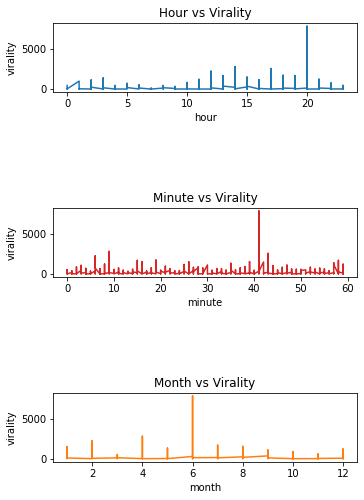

In [ ]:
fig, axs = plt.subplots(3, 1)

y = list(data['VIRALITY'])
x = list(data['timestamp'].apply(datetime.fromtimestamp).dt.hour)
df = pd.DataFrame({'hour': x, 'virality': y})
df.sort_values('hour', inplace=True)

axs[0].plot(df['hour'], df['virality'])
axs[0].set_title('Hour vs Virality')

y = list(data['VIRALITY'])
x = list(data['timestamp'].apply(datetime.fromtimestamp).dt.minute)
df = pd.DataFrame({'minute': x, 'virality': y})
df.sort_values('minute', inplace=True)

axs[1].plot(df['minute'], df['virality'], 'tab:red')
axs[1].set_title('Minute vs Virality')

y = list(data['VIRALITY'])
x = list(data['timestamp'].apply(datetime.fromtimestamp).dt.month)
df = pd.DataFrame({'month': x, 'virality': y})
df.sort_values('month', inplace=True)

axs[2].plot(df['month'], df['virality'], 'tab:orange')
axs[2].set_title('Month vs Virality')

units = ['hour', 'minute', 'month']

for i, ax in enumerate(axs.flat):
    ax.set(xlabel=units[i], ylabel='virality')

fig.tight_layout()
fig.set_size_inches(5, 8)
fig.show()

Since the patterns don't give a clear idea (peaks are result of large values), hence time is not considered for the ML model.

In [ ]:
data.drop('timestamp', axis=1, inplace=True)

##### Correlation Matrix Between Numerical Values

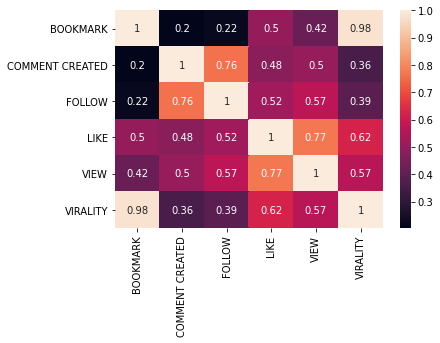

In [ ]:
corr_mat = data.corr()
sns.heatmap(corr_mat, annot=True)

plt.show()

As we can see from above, numerical variables are correlated with Virality in the following order (High to Low): Bookmark, Like, View, Follow and Comment Created, which is differing from the order of the coefficients as per the problem statement.

### Machine Learning Model

I would examine the model under two conditions. One with text and title information and one without considering it. The ML models considered for the project are: Linear Regression, Polynomial Regression, Random Forest, and Lasso.

#### Linear Regression

In [ ]:
def linear_reg(X_train, X_test, y_train, y_test):

  model = LinearRegression(n_jobs=-1)
    
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  print("R-Square Value:", r2_score(y_test, y_pred))
  print("Root Mean-Square Error:", mean_squared_error(y_test, y_pred, squared=False))
  print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred), "\n")

#### Polynomial Regression

In [ ]:
def polynomial_reg(X_train, X_test, y_train, y_test):

  transformer = PolynomialFeatures(degree=2, include_bias=False)
  transformer.fit(X_train)

  x_ = transformer.transform(X_train)

  model = LinearRegression(n_jobs=-1)
    
  model.fit(x_, y_train)

  y_pred = model.predict(transformer.transform(X_test))

  print("R-Square Value:", r2_score(y_test, y_pred))
  print("Root Mean-Square Error:", mean_squared_error(y_test, y_pred, squared=False))
  print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred), "\n")

#### Random-Forest Regression

In [ ]:
def rf_reg(X_train, X_test, y_train, y_test):

  model = RandomForestRegressor(n_jobs=-1, random_state=2020)
    
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  print("R-Square Value:", r2_score(y_test, y_pred))
  print("Root Mean-Square Error:", mean_squared_error(y_test, y_pred, squared=False))
  print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred), "\n")

#### Lasso

In [ ]:
def lasso(X_train, X_test, y_train, y_test):

  model = Lasso(random_state=2020)
    
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  print("R-Square Value:", r2_score(y_test, y_pred))
  print("Root Mean-Square Error:", mean_squared_error(y_test, y_pred, squared=False))
  print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred), "\n")

#### Call for all models

In [ ]:
def run_models(X_train, X_test, y_train, y_test):

  print("Linear Regression:")
  linear_reg(X_train, X_test, y_train, y_test)

  print("Polynomial Regression:")
  polynomial_reg(X_train, X_test, y_train, y_test)

  print("Random-Forest Regression:")
  rf_reg(X_train, X_test, y_train, y_test)

  print("Lasso:")
  lasso(X_train, X_test, y_train, y_test)

#### Data with Numerical Parameters

In [ ]:
data_num = data[['BOOKMARK',	'COMMENT CREATED', 'FOLLOW',	'LIKE',	'VIEW',	'VIRALITY']]

##### Train-Test Split

80% Training Data, 20% Test Data

In [ ]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(data_num[['BOOKMARK',	'COMMENT CREATED', 'FOLLOW',	'LIKE',	'VIEW']], data_num['VIRALITY'], test_size=0.2, random_state = 2020)

#### Data with Numerical and Text Parameters

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=token_stem, max_features=100)

tfidf = vectorizer.fit_transform(data['title'] + data['text'])
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)

In [ ]:
data_all = data.copy()

data_all.reset_index(drop=True, inplace=True)
data_all.drop(['text', 'title'], axis = 1, inplace=True)

data_all = pd.concat([data_all, tfidf_df], axis = 1)

data_all.head()

,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,1,0,5,50,80,0.000000,0.129385,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104597,0.082579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.902081,0.154726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.091642,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.089556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090259,0.055328,0.082348,0.000000,0.000000,0.080761,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,0,1,8,12,0.000000,0.021689,0.000000,0.00000,0.0,0.000000,0.028663,0.000000,0.000000,0.028762,0.000000,0.000000,0.000000,0.055904,0.000000,0.000000,0.000000,0.293201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026303,0.000000,0.000000,0.000000,0.00000,0.153621,0.053297,0.0,0.000000,...,0.000000,0.000000,0.028223,0.000000,0.000000,0.270101,0.000000,0.569318,0.0,0.000000,0.000000,0.063709,0.030932,0.000000,0.029882,0.000000,0.0,0.000000,0.054123,0.032985,0.000000,0.000000,0.064945,0.000000,0.000000,0.028466,0.000000,0.045583,0.000000,0.000000,0.000000,0.082825,0.000000,0.047707,0.000000,0.000000,0.000000,0.031066,0.084477,0.000000
2,2,0,0,1,33,237,0.000000,0.013844,0.083179,0.28148,0.0,0.136445,0.073183,0.040435,0.029363,0.045898,0.013464,0.000000,0.035344,0.142736,0.011768,0.018434,0.025599,0.145563,0.073692,0.021450,0.157280,0.154356,0.000000,0.172693,0.011707,0.025184,0.103170,0.028106,0.090183,0.02969,0.009806,0.051030,0.0,0.019708,...,0.042756,0.059343,0.135112,0.000000,0.097838,0.183183,0.030694,0.109020,0.0,0.046218,0.010632,0.030500,0.059233,0.058070,0.028610,0.009583,0.0,0.022935,0.043184,0.000000,0.009583,0.041860,0.072546,0.062956,0.023104,0.372485,0.274322,0.043644,0.000000,0.009658,0.183524,0.008811,0.046583,0.167484,0.138264,0.101229,0.117086,0.168555,0.062909,0.061679
3,1,0,0,0,4,104,0.000000,0.040832,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.057735,0.000000,0.000000,0.000000,0.104242,0.000000,0.000000,0.054368,0.000000,0.000000,0.000000,0.126525,0.097657,0.053559,0.465918,0.000000,0.000000,0.099035,0.060857,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.053132,0.000000,0.769487,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.119938,0.000000,0.146801,0.056255,0.000000,0.0,0.000000,0.000000,0.062097,0.000000,0.000000,0.000000,0.000000,0.000000,0.053590,0.000000,0.000000,0.000000,0.000000,0.104763,0.051975,0.000000,0.044906,0.000000,0.000000,0.000000,0.058485,0.000000,0.000000
4,0,0,0,0,5,5,0.047529,0.065749,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.043596,0.191834,0.000000,0.041964,0.000000,0.167668,0.000000,0.000000,0.049379,0.000000,0.152803,0.039313,0.129365,0.000000,0.000000,0.166791,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.046798,...,0.000000,0.000000,0.000000,0.269379,0.000000,0.000000,0.000000,0.043146,0.0,0.087800,0.050494,0.193131,0.000000,0.118193,0.090584,0.000000,0.0,0.000000,0.041017,0.049996,0.136528,0.159041,0.000000,0.049832,0.219446,0.000000,0.048252,0.379998,0.050968,0.000000,0.168695,0.125539,0.000000,0.036155,0.000000,0.120189,0.000000,0.000000,0.000000,0.000000


##### Train-Test Split

80% Training Data, 20% Test Data

In [ ]:
cols = list(data_all.columns)
cols.remove('VIRALITY')

X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(data_all[cols], data_all['VIRALITY'], test_size=0.2, random_state = 2020)

#### Run Models with Numerical Values

In [ ]:
run_models(X_train_n, X_test_n, y_train_n, y_test_n)

Linear Regression:
R-Square Value: 1.0
Root Mean-Square Error: 1.6947611102931463e-13
Mean Absolute Error: 1.0771951805995635e-13 

Polynomial Regression:
R-Square Value: 1.0
Root Mean-Square Error: 5.81519588348364e-12
Mean Absolute Error: 3.8789540055436086e-12 

Random-Forest Regression:
R-Square Value: 0.9897210705906804
Root Mean-Square Error: 20.39898204254549
Mean Absolute Error: 4.552465116279071 

Lasso:
R-Square Value: 0.9999515752706049
Root Mean-Square Error: 1.4001293357684252
Mean Absolute Error: 0.843623856274001 



#### Run Models with Numerical and Text Values

In [ ]:
run_models(X_train_nt, X_test_nt, y_train_nt, y_test_nt)

Linear Regression:
R-Square Value: 1.0
Root Mean-Square Error: 2.7331602770420595e-12
Mean Absolute Error: 1.903684961606296e-12 

Polynomial Regression:
R-Square Value: 0.9999986141612645
Root Mean-Square Error: 0.23685955113821153
Mean Absolute Error: 0.13073436318995293 

Random-Forest Regression:
R-Square Value: 0.931605899001929
Root Mean-Square Error: 52.6191558474005
Mean Absolute Error: 9.221418604651161 

Lasso:
R-Square Value: 0.9999515752706049
Root Mean-Square Error: 1.4001293357684246
Mean Absolute Error: 0.8436238562740009 

